In [2]:
import os
import re

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc

In [3]:
import torch
from torchvision import datasets, transforms

from vit_pytorch import ViT, Dino

In [4]:
import mgitools.os_helpers as os_helpers

In [5]:
import violet

## loading in data

In [190]:
adata = sc.read_h5ad('/home/estorrs/spatial-analysis/data/breast/model_inputs_06092021/adata.h5ad')
adata

AnnData object with n_obs × n_vars = 290233 × 0
    obs: 'in_tissue', 'array_row', 'array_col', 'sample_id'
    obsm: 'spatial'

In [191]:
adata.obs

in_tissue  array_row  array_col  \
HT206B1_H8_U2_AAACAACGAATAGTTC-1          1          0         16   
HT206B1_H8_U2_AAACAAGTATCTCCCA-1          1         50        102   
HT206B1_H8_U2_AAACAATCTACTAGCA-1          1          3         43   
HT206B1_H8_U2_AAACACCAATAACTGC-1          1         59         19   
HT206B1_H8_U2_AAACAGAGCGACTCCT-1          1         14         94   
...                                     ...        ...        ...   
HT291C1_U1_TTGTTTCACATCCAGG-1             1         58         42   
HT291C1_U1_TTGTTTCATTAGTCTA-1             1         60         30   
HT291C1_U1_TTGTTTCCATACAACT-1             1         45         27   
HT291C1_U1_TTGTTTGTATTACACG-1             1         73         41   
HT291C1_U1_TTGTTTGTGTAAATTC-1             1          7         51   

                                      sample_id  
HT206B1_H8_U2_AAACAACGAATAGTTC-1  HT206B1_H8_U2  
HT206B1_H8_U2_AAACAAGTATCTCCCA-1  HT206B1_H8_U2  
HT206B1_H8_U2_AAACAATCTACTAGCA-1  HT206B1_H8_U2  
HT206B1_H8_U2_AAACACCAATAACTGC-1  HT206B1_H8_U2  
HT206B1_H8_U2_AAACAGAGCGACTCCT-1  HT206B1_H8_U2  
...                                         ...  
HT291C1_U1_TTGTTTCACATCCAGG-1        HT291C1_U1  
HT291C1_U1_TTGTTTCATTAGTCTA-1        HT291C1_U1  
HT291C1_U1_TTGTTTCCATACAACT-1        HT291C1_U1  
HT291C1_U1_TTGTTTGTATTACACG-1        HT291C1_U1  
HT291C1_U1_TTGTTTGTGTAAATTC-1        HT291C1_U1  

[290233 rows x 4 columns]

In [183]:
imgs = sorted(os_helpers.listfiles('/home/estorrs/spatial-analysis/data/breast/model_inputs_06092021/he_imgs_by_sample/'))
len(imgs)

290336

In [184]:
diseases = sorted(set([i.split('/')[-3] for i in imgs]))
diseases

['brca',
 'brca_met',
 'ccrcc',
 'cholangiocarcinoma',
 'co',
 'co_met',
 'gbm',
 'he_imgs_by_sample',
 'lusl_pdx',
 'model_inputs_06092021',
 'mouse_bladder',
 'mouse_kidney',
 'mouse_prostate',
 'normal_liver',
 'normal_stomach',
 'pdac',
 'ucec']

In [185]:
# keep = ['brca',
#  'brca_met',
#  'ccrcc',
#  'cholangiocarcinoma',
#  'co',
#  'co_met',
#  'gbm',
#  'normal_liver',
#  'normal_stomach',
#  'pdac',
#  'ucec']

keep = ['co_met']
imgs = [i for i in imgs if i.split('/')[-3] in keep]
len(imgs)

21992

In [186]:
from collections import Counter
Counter([i.split('/')[-3] for i in imgs]).most_common()

[('co_met', 21992)]

In [187]:
samples = sorted(set(['|'.join(i.split('/')[-3:-1]) for i in imgs]))
samples

['co_met|HT165C1A3',
 'co_met|HT213C1A4_U1',
 'co_met|HT230C1_U1',
 'co_met|HT250C1',
 'co_met|HT253C1T1',
 'co_met|HT260C1Th1K1_U1']

In [188]:
Counter([s.split('|')[0] for s in samples]).most_common()

[('co_met', 6)]

In [192]:
# match adata to imgs
idxs = [i.split('/')[-1].split('.')[0] for i in imgs]
adata = adata[idxs]
adata, len(imgs)

(View of AnnData object with n_obs × n_vars = 21992 × 0
     obs: 'in_tissue', 'array_row', 'array_col', 'sample_id'
     obsm: 'spatial',
 21992)

only need the below if you are moving images around for first time in notebook

In [194]:
from sklearn.model_selection import train_test_split

In [195]:
idxs = np.arange(len(imgs))
train, val = train_test_split([idxs.reshape(-1, 1), idxs.reshape(-1, 1)])
len(train), len(val)

(1, 1)

In [196]:
# save for training
# go ahead and split by sample
import shutil
from pathlib import Path
target = '/home/estorrs/spatial-analysis/data/breast/model_inputs_06092021/co_met_he_imgs'
idxs = np.arange(len(imgs))
train_idxs, val_idxs = np.split(idxs, [int(len(idxs) * .95)])
for x in ['train', 'val']:
    for y in keep:
        Path(os.path.join(target, x, y)).mkdir(parents=True, exist_ok=True)
for i in train_idxs:
    img = imgs[i]
    p = os.path.join(target, 'train', img.split('/')[-3], img.split('/')[-1])
    shutil.copy(img, p)
for i in val_idxs:
    img = imgs[i]
    p = os.path.join(target, 'val', img.split('/')[-3], img.split('/')[-1])
    shutil.copy(img, p)

## sandboxing

#### lucid vit

In [16]:
adata

View of AnnData object with n_obs × n_vars = 210756 × 0
    obs: 'in_tissue', 'array_row', 'array_col', 'sample_id'
    obsm: 'spatial'

In [17]:
img_dir = '/home/estorrs/spatial-analysis/data/breast/model_inputs_06092021/he_imgs_v2'
out_dir = '../sandbox/results/vit_dino_test_1'
Path(out_dir).mkdir(parents=True, exist_ok=True)

In [18]:
model = ViT(
    image_size = 256,
    patch_size = 16,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048
)
model = model.cuda()

In [19]:
learner = Dino(
    model,
    image_size = 256,
    hidden_layer = 'to_latent',        # hidden layer name or index, from which to extract the embedding
    projection_hidden_size = 256,      # projector network hidden dimension
    projection_layers = 4,             # number of layers in projection network
    num_classes_K = 65336,             # output logits dimensions (referenced as K in paper)
    student_temp = 0.9,                # student temperature
    teacher_temp = 0.04,               # teacher temperature, needs to be annealed from 0.04 to 0.07 over 30 epochs
    local_upper_crop_scale = 0.4,      # upper bound for local crop - 0.4 was recommended in the paper 
    global_lower_crop_scale = 0.5,     # lower bound for global crop - 0.5 was recommended in the paper
    moving_average_decay = 0.9,        # moving average of encoder - paper showed anywhere from 0.9 to 0.999 was ok
    center_moving_average_decay = 0.9, # moving average of teacher centers - paper showed anywhere from 0.9 to 0.999 was ok
)
learner = learner.cuda()

In [20]:
def sample_unlabelled_images():
    return torch.randn(20, 3, 256, 256)

In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
])

In [22]:
train_dataset = datasets.ImageFolder(os.path.join(img_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(img_dir, 'val'), transform=transform)
train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=64,
    drop_last=True,
)
val_data_loader = torch.utils.data.DataLoader(
    val_dataset,
    shuffle=False,
    batch_size=64,
    drop_last=True,
)

In [23]:
opt = torch.optim.Adam(learner.parameters(), lr = 3e-4)

In [24]:
from torch.utils.tensorboard import SummaryWriter
log_dir = os.path.join(out_dir, 'logs')
Path(log_dir).mkdir(exist_ok=True, parents=True)
writer = SummaryWriter(log_dir)

In [25]:
# # helper function
# def select_n_random(data, labels, n=100):
#     '''
#     Selects n random datapoints and their corresponding labels from a dataset
#     '''
#     assert len(data) == len(labels)

#     perm = torch.randperm(len(data))
#     return data[perm][:n], labels[perm][:n]

# # select random images and their target indices
# images, labels = select_n_random(trainset.data, trainset.targets)

# # get the class labels for each image
# class_labels = [classes[lab] for lab in labels]

# # log embeddings
# features = images.view(-1, 28 * 28)
# writer.add_embedding(features,
#                     metadata=class_labels,
#                     label_img=images.unsqueeze(1))

In [26]:
torch.cuda.device_count(), torch.cuda.is_available()

(4, True)

In [27]:
device = torch.device("cuda:0")

In [ ]:
save_every = 2

for epoch in range(5):
    train_loss, val_loss = 0., 0.
    
    learner.train()
    for i, (images, _) in enumerate(train_data_loader):
        if i % 10 == 0:
            print(epoch, i, len(train_data_loader))
        images = images.to(device)
        loss = learner(images)
        opt.zero_grad()
        loss.backward()
        opt.step()
        learner.update_moving_average() # update moving average of teacher encoder and teacher centers
        
        train_loss += loss
        
    learner.eval()
    with torch.no_grad():
        for i, (images, _) in enumerate(val_data_loader):
            images = images.to(device)
            loss = learner(images)
            learner.update_moving_average() # update moving average of teacher encoder and teacher centers

            val_loss += loss    

    train_loss = train_loss / len(train_data_loader)
    val_loss = val_loss / len(val_data_loader)
    
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)
    print(f'epoch: {epoch}, train loss: {train_loss}, val loss: {val_loss}')
    
    if i % save_every == 0:
        # save your improved network
        print('saving checkpoint at', os.path.join(out_dir, f'checkpoint_{epoch}.pt'))
        torch.save(model.state_dict(), os.path.join(out_dir, f'checkpoint_{epoch}.pt'))
        
writer.flush()

0 0 3128
0 10 3128
0 20 3128
0 30 3128
0 40 3128
0 50 3128
0 60 3128
0 70 3128
0 80 3128
0 90 3128
0 100 3128
0 110 3128
0 120 3128
0 130 3128
0 140 3128
0 150 3128
0 160 3128
0 170 3128
0 180 3128
0 190 3128
0 200 3128
0 210 3128
0 220 3128
0 230 3128
0 240 3128
0 250 3128
0 260 3128
0 270 3128
0 280 3128
0 290 3128
0 300 3128
0 310 3128
0 320 3128
0 330 3128
0 340 3128
0 350 3128
0 360 3128
0 370 3128
0 380 3128
0 390 3128
0 400 3128
0 410 3128
0 420 3128
0 430 3128
0 440 3128
0 450 3128
0 460 3128
0 470 3128
0 480 3128
0 490 3128
0 500 3128
0 510 3128
0 520 3128
0 530 3128
0 540 3128
0 550 3128
0 560 3128
0 570 3128
0 580 3128
0 590 3128
0 600 3128
0 610 3128
0 620 3128
0 630 3128
0 640 3128
0 650 3128
0 660 3128
0 670 3128
0 680 3128
0 690 3128
0 700 3128
0 710 3128
0 720 3128
0 730 3128
0 740 3128
0 750 3128
0 760 3128
0 770 3128
0 780 3128
0 790 3128
0 800 3128
0 810 3128
0 820 3128
0 830 3128
0 840 3128
0 850 3128
0 860 3128
0 870 3128
0 880 3128
0 890 3128
0 900 3128
0 910 3128

2 710 3128
2 720 3128
2 730 3128
2 740 3128
2 750 3128
2 760 3128
2 770 3128
2 780 3128
2 790 3128
2 800 3128
2 810 3128
2 820 3128
2 830 3128
2 840 3128
2 850 3128
2 860 3128
2 870 3128
2 880 3128
2 890 3128
2 900 3128
2 910 3128
2 920 3128
2 930 3128
2 940 3128
2 950 3128
2 960 3128
2 970 3128
2 980 3128
2 990 3128
2 1000 3128
2 1010 3128
2 1020 3128
2 1030 3128
2 1040 3128
2 1050 3128
2 1060 3128
2 1070 3128
2 1080 3128
2 1090 3128
2 1100 3128
2 1110 3128
2 1120 3128
2 1130 3128
2 1140 3128
2 1150 3128
2 1160 3128
2 1170 3128
2 1180 3128
2 1190 3128
2 1200 3128
2 1210 3128
2 1220 3128
2 1230 3128
2 1240 3128
2 1250 3128
2 1260 3128
2 1270 3128
2 1280 3128
2 1290 3128
2 1300 3128
2 1310 3128
2 1320 3128
2 1330 3128
2 1340 3128
2 1350 3128
2 1360 3128
2 1370 3128
2 1380 3128
2 1390 3128
2 1400 3128
2 1410 3128
2 1420 3128
2 1430 3128
2 1440 3128
2 1450 3128
2 1460 3128
2 1470 3128
2 1480 3128
2 1490 3128
2 1500 3128
2 1510 3128
2 1520 3128
2 1530 3128
2 1540 3128
2 1550 3128
2 1560 31

In [ ]:
3128 / 10

#### load in facebook dino pretrained vit

In [10]:
import violet
from violet.models import VisionTransformer, vit_small
from violet.utils.dino_utils import load_pretrained_weights

In [11]:
from torchvision import datasets, transforms
from torchvision import models as torchvision_models

In [12]:
torchvision_models.__dict__.keys()

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__path__', '__file__', '__cached__', '__builtins__', 'utils', 'alexnet', 'AlexNet', 'resnet', 'ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnext50_32x4d', 'resnext101_32x8d', 'wide_resnet50_2', 'wide_resnet101_2', 'vgg', 'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'squeezenet', 'SqueezeNet', 'squeezenet1_0', 'squeezenet1_1', 'inception', 'Inception3', 'inception_v3', 'InceptionOutputs', '_InceptionOutputs', 'densenet', 'DenseNet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'googlenet', 'GoogLeNet', 'GoogLeNetOutputs', '_GoogLeNetOutputs', 'mobilenetv2', 'mobilenetv3', 'mobilenet', 'MobileNetV2', 'mobilenet_v2', 'MobileNetV3', 'mobilenet_v3_large', 'mobilenet_v3_small', 'mnasnet', 'MNASNet', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'shufflenetv2', 'ShuffleNetV2', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0

In [13]:
patch_size = 16
model = vit_small(num_classes=0)
model.cuda()
load_pretrained_weights(model, '/home/estorrs/dino/outputs/all_human_06152021/checkpoint0160.pth',
                        'teacher', 'vit_small', patch_size)

Take key teacher in provided checkpoint dict
Pretrained weights found at /home/estorrs/dino/outputs/all_human_06152021/checkpoint0160.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


In [179]:
patch_size = 16
model = vit_small(num_classes=0)
model.cuda()
load_pretrained_weights(model, '/home/estorrs/dino/outputs/test_run_5_brca_good_only/checkpoint0480.pth',
                        'teacher', 'vit_small', patch_size)

Take key teacher in provided checkpoint dict
Pretrained weights found at /home/estorrs/dino/outputs/test_run_5_brca_good_only/checkpoint0480.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


In [181]:
img_dir = '/home/estorrs/spatial-analysis/data/breast/model_inputs_06092021/he_imgs_v2'

In [63]:
means = torch.zeros(3).cuda()
stds = torch.zeros(3).cuda()
for inputs, _ in train_data_loader:
    inputs = inputs.cuda()
    for i in range(3):
        means[i] += torch.mean(inputs[:, i, :, :])
        stds[i] += torch.std(inputs[:, i, :, :])
means = means / len(train_data_loader)
stds = stds / len(train_data_loader)
means, stds

(tensor([0.6591, 0.5762, 0.7749], device='cuda:0'),
 tensor([0.2273, 0.2373, 0.1685], device='cuda:0'))

In [182]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Resize((256, 256)),
# ])
transform = transforms.Compose([
        transforms.Resize(256, interpolation=3),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
#         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        transforms.Normalize((0.6591, 0.5762, 0.7749), (0.2273, 0.2373, 0.1685)),
    ])

/home/estorrs/miniconda3/envs/violet/lib/python3.8/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [16]:
# test inference
train_dataset = datasets.ImageFolder(os.path.join(img_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(img_dir, 'val'), transform=transform)
train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=64,
    drop_last=True,
)
val_data_loader = torch.utils.data.DataLoader(
    val_dataset,
    shuffle=False,
    batch_size=64,
    drop_last=True,
)

In [36]:
imgs, y = next(iter(train_data_loader))
imgs.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [37]:
train_data_loader.dataset.class_to_idx

{'brca': 0,
 'brca_met': 1,
 'ccrcc': 2,
 'cholangiocarcinoma': 3,
 'co': 4,
 'co_met': 5,
 'gbm': 6,
 'normal_liver': 7,
 'normal_stomach': 8,
 'pdac': 9,
 'ucec': 10}

In [38]:
imgs, y = imgs.cuda(), y.cuda()

In [39]:
model.eval()
with torch.no_grad():
    out = model(imgs)
    attn = model.get_last_selfattention(imgs)
out, attn = out.cpu().numpy(), attn.cpu().numpy()
out.shape, attn.shape

((64, 384), (64, 6, 197, 197))

In [40]:
## (b, h, d, d) where d = n_patches + 1
from scipy.interpolate import interp1d
imgs = np.swapaxes(imgs.cpu().numpy(), 1, 3)
m = interp1d([np.min(imgs), np.max(imgs)],[0,1])
imgs = m(imgs)

In [41]:
imgs.shape

(64, 224, 224, 3)

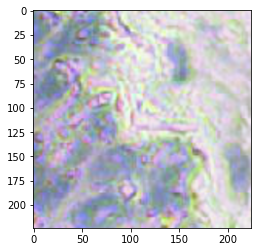

In [42]:
import matplotlib.pyplot as plt
plt.imshow(imgs[0])

In [43]:
def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"
    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap

In [55]:
from skimage.transform import resize

In [126]:
def plot_attention(img, attn, num_patches=14, figsize=(10, 4), display='head'):
    # img: (h, w, c)
    # attn: (n_heads, d, d)
    #Use base cmap to create transparent
    cm = transparent_cmap(plt.cm.Reds)
    
    y, x = img.shape[0], img.shape[1]

    #Plot image and overlay colormap
    # if displaying every head
    if display=='head':
        fig, axs = plt.subplots(3, attn.shape[0], figsize=figsize)
        for i in range(attn.shape[0]):
            axs[0, i].imshow(img)
            axs[1, i].imshow(img)

            # keep only patch attention
            head_attn = attn[i, 0, 1:]
            head_attn = head_attn.reshape(num_patches, num_patches)
            axs[0, i].imshow(resize(head_attn, (img.shape[0], img.shape[1])), cmap=cm)
            axs[2, i].imshow(head_attn, cmap=cm)
            for ax in axs[:, i]: ax.set_axis_off()
    else:
        fig, axs = plt.subplots(3, 1, figsize=figsize)
        axs[0].imshow(img)
        axs[1].imshow(img)
        mean_attn = attn[:, 0, 1:].reshape(attn.shape[0], num_patches, num_patches)
        print(mean_attn.shape)
#         mean_attn = np.mean(mean_attn, axis=0)
        mean_attn = mean_attn.mean(axis=0)
        print(mean_attn.shape)
        axs[0].imshow(resize(mean_attn, (img.shape[0], img.shape[1])), cmap=cm)
        axs[2].imshow(mean_attn, cmap=cm)
        for ax in axs: ax.set_axis_off()
    
    
        
    return fig, axs

In [60]:
imgs.shape

(64, 224, 224, 3)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

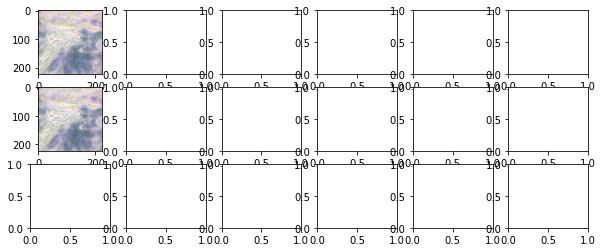

In [117]:
plot_attention(imgs[1], attn[1])

In [64]:
import copy

###### do hacky transfer learning

In [65]:
finetuned = copy.deepcopy(model)

In [66]:
targets = pd.read_csv('/home/estorrs/spatial-analysis/data/breast/model_inputs_06092021/brca_annotations.txt', sep='\t',
                index_col=0)
targets

CD8-T  Endothelial       CAF  \
HT206B1_H8_U1_AAACAAGTATCTCCCA-1    0.002781     0.051927  0.334458   
HT206B1_H8_U1_AAACAATCTACTAGCA-1    0.000000     0.000000  0.119018   
HT206B1_H8_U1_AAACACCAATAACTGC-1    0.000000     0.000000  0.066781   
HT206B1_H8_U1_AAACAGAGCGACTCCT-1    0.000000     0.000000  0.008322   
HT206B1_H8_U1_AAACAGCTTTCAGAAG-1    0.000000     0.000000  0.059723   
...                                      ...          ...       ...   
HT265B1_H1A2_U1_TTGTTTCACATCCAGG-1  0.000000     0.091920  0.022763   
HT265B1_H1A2_U1_TTGTTTCATTAGTCTA-1  0.000000     0.000000  0.000000   
HT265B1_H1A2_U1_TTGTTTCCATACAACT-1  0.000000     0.000000  0.000000   
HT265B1_H1A2_U1_TTGTTTGTATTACACG-1  0.000000     0.036072  0.060534   
HT265B1_H1A2_U1_TTGTTTGTGTAAATTC-1  0.000000     0.000000  0.011958   

                                    Normal-duct   NK  Mono-Macro      Treg  \
HT206B1_H8_U1_AAACAAGTATCTCCCA-1       0.198311  0.0    0.000000  0.000000   
HT206B1_H8_U1_AAACAATCTACTAGCA-1       0.071357  0.0    0.000000  0.000000   
HT206B1_H8_U1_AAACACCAATAACTGC-1       0.000000  0.0    0.874991  0.000000   
HT206B1_H8_U1_AAACAGAGCGACTCCT-1       0.251230  0.0    0.000000  0.000000   
HT206B1_H8_U1_AAACAGCTTTCAGAAG-1       0.722219  0.0    0.000000  0.000000   
...                                         ...  ...         ...       ...   
HT265B1_H1A2_U1_TTGTTTCACATCCAGG-1     0.230603  0.0    0.000000  0.000000   
HT265B1_H1A2_U1_TTGTTTCATTAGTCTA-1     0.000000  0.0    0.000000  0.000000   
HT265B1_H1A2_U1_TTGTTTCCATACAACT-1     0.000000  0.0    0.000000  0.000000   
HT265B1_H1A2_U1_TTGTTTGTATTACACG-1     0.019267  0.0    0.179706  0.052119   
HT265B1_H1A2_U1_TTGTTTGTGTAAATTC-1     0.003709  0.0    0.891325  0.000000   

                                       CD4-T        DC  NKT-cells         B  \
HT206B1_H8_U1_AAACAAGTATCTCCCA-1    0.000000  0.000000        0.0  0.006113   
HT206B1_H8_U1_AAACAATCTACTAGCA-1    0.000000  0.000000        0.0  0.000000   
HT206B1_H8_U1_AAACACCAATAACTGC-1    0.000000  0.039538        0.0  0.000000   
HT206B1_H8_U1_AAACAGAGCGACTCCT-1    0.007088  0.000000        0.0  0.000000   
HT206B1_H8_U1_AAACAGCTTTCAGAAG-1    0.000000  0.000000        0.0  0.000000   
...                                      ...       ...        ...       ...   
HT265B1_H1A2_U1_TTGTTTCACATCCAGG-1  0.000000  0.000000        0.0  0.000000   
HT265B1_H1A2_U1_TTGTTTCATTAGTCTA-1  0.000000  0.000000        0.0  0.000000   
HT265B1_H1A2_U1_TTGTTTCCATACAACT-1  0.000000  0.000000        0.0  0.000000   
HT265B1_H1A2_U1_TTGTTTGTATTACACG-1  0.213279  0.296608        0.0  0.000000   
HT265B1_H1A2_U1_TTGTTTGTGTAAATTC-1  0.000000  0.058567        0.0  0.000000   

                                      Plasma  Mast     Tumor  
HT206B1_H8_U1_AAACAAGTATCTCCCA-1    0.000000   0.0  0.406411  
HT206B1_H8_U1_AAACAATCTACTAGCA-1    0.000000   0.0  0.809625  
HT206B1_H8_U1_AAACACCAATAACTGC-1    0.000000   0.0  0.018690  
HT206B1_H8_U1_AAACAGAGCGACTCCT-1    0.000000   0.0  0.733360  
HT206B1_H8_U1_AAACAGCTTTCAGAAG-1    0.000000   0.0  0.218059  
...                                      ...   ...       ...  
HT265B1_H1A2_U1_TTGTTTCACATCCAGG-1  0.000000   0.0  0.654713  
HT265B1_H1A2_U1_TTGTTTCATTAGTCTA-1  1.000000   0.0  0.000000  
HT265B1_H1A2_U1_TTGTTTCCATACAACT-1  0.992881   0.0  0.007119  
HT265B1_H1A2_U1_TTGTTTGTATTACACG-1  0.022246   0.0  0.120168  
HT265B1_H1A2_U1_TTGTTTGTGTAAATTC-1  0.000000   0.0  0.034441  

[60747 rows x 14 columns]

In [67]:
# your going to have to do some custom dataloaders
from torchvision.datasets.folder import default_loader

In [68]:
import mgitools.os_helpers as os_helpers
class ImageRegressionDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, target_df, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        pool = set(target_df.index)
        self.imgs = sorted(os_helpers.listfiles(root_dir))
        self.imgs = [i for i in self.imgs if i.split('/')[-1].split('.')[0] in pool]
        idxs = [i.split('/')[-1].split('.')[0] for i in self.imgs]
        target_df = target_df.loc[idxs]
        
        self.targets = target_df.values
        self.labels = np.asarray(target_df.columns)
        self.samples = np.asarray(target_df.index.to_list())

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_loc = self.imgs[idx]
        image = default_loader(img_loc)
        target = torch.tensor(self.targets[idx], dtype=torch.float32)
        if self.transform is not None:
            tensor_image = self.transform(image)
        return tensor_image, target

In [69]:
# test inference
train_root = '/home/estorrs/spatial-analysis/data/breast/model_inputs_v11_brca_good_only/he_load_from_dir/train/'
val_root = '/home/estorrs/spatial-analysis/data/breast/model_inputs_v11_brca_good_only/he_load_from_dir/val/'
train_dataset = ImageRegressionDataset(train_root, targets, transform=transform)
val_dataset = ImageRegressionDataset(val_root, targets, transform=transform)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=64,
    drop_last=True,
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    shuffle=False,
    batch_size=64,
    drop_last=True,
)

In [75]:
xs, ys = next(iter(train_dataloader))

In [71]:
xs.shape, ys.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [72]:
xs.dtype, ys.dtype

(torch.float32, torch.int64)

In [73]:
ys[0]

tensor(2)

In [76]:
train_dataloader.dataset.labels

array(['CD8-T', 'Endothelial', 'CAF', 'Normal-duct', 'NK', 'Mono-Macro',
       'Treg', 'CD4-T', 'DC', 'NKT-cells', 'B', 'Plasma', 'Mast', 'Tumor'],
      dtype=object)

In [77]:
import torch.nn as nn

In [83]:
# attach classification head to model
class RegressionHead(nn.Module):
    def __init__(self, in_dim, out_dim, drop=0.):
        super().__init__()
        
#         self.net = nn.Sequential(
#             nn.Linear(in_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Dropout(drop),
#             nn.Linear(hidden_dim, in_dim),
#             nn.ReLU(),
#             nn.Dropout(drop),
#             nn.Linear(in_dim, out_dim),
#         )
        self.net = nn.Sequential(
            nn.Linear(in_dim, out_dim),
        )

    def forward(self, x):
        return self.net(x)

In [84]:
class TestModel(nn.Module):
    def __init__(self, model, in_dim, out_dim, drop=0.):
        super().__init__()
        
        self.vit = model
        self.head = RegressionHead(in_dim, out_dim, drop=drop)
        
        # freeze vit weights
        for param in self.vit.parameters():
            param.requires_grad = False
            
    def unfreeze_vit(self):
        for param in self.vit.parameters():
            param.requires_grad = True
        
    def forward(self, x):
        cls_token = self.vit(x)
        return self.head(cls_token)
        

In [85]:
# clf = TestModel(copy.deepcopy(model), 384, 564, len(train_data_loader.dataset.labels), drop=.2)
clf = TestModel(copy.deepcopy(model), 384, len(train_dataloader.dataset.labels), drop=.2)

clf = clf.cuda()

In [86]:
max_lr = 1e-4
epochs = 10

mse_loss = nn.MSELoss()
opt = torch.optim.Adam(clf.parameters(), lr=max_lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=max_lr,
                                                steps_per_epoch=len(train_dataloader), epochs=epochs)

In [87]:
for epoch in range(epochs):
    train_loss, val_loss = 0., 0.
    
    clf.train()
    for i, (x, y) in enumerate(train_dataloader):
        x, y = x.cuda(), y.cuda()
        logit = clf(x)
        loss = mse_loss(logit, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
                
        train_loss += loss
    scheduler.step()
        
    clf.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(val_dataloader):
            x, y = x.cuda(), y.cuda()
            logit = clf(x)
            loss = mse_loss(logit, y)
            
            val_loss += loss    

    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    
    print(f'epoch: {epoch}, train loss: {train_loss}, val loss: {val_loss}')


epoch: 0, train loss: 0.6165416240692139, val loss: 0.5875402688980103
epoch: 1, train loss: 0.5175069570541382, val loss: 0.49280011653900146
epoch: 2, train loss: 0.4437750577926636, val loss: 0.4212988317012787
epoch: 3, train loss: 0.38764330744743347, val loss: 0.3666952848434448
epoch: 4, train loss: 0.34359970688819885, val loss: 0.3241182565689087
epoch: 5, train loss: 0.30819740891456604, val loss: 0.2901320159435272
epoch: 6, train loss: 0.27938762307167053, val loss: 0.2627480626106262
epoch: 7, train loss: 0.25539204478263855, val loss: 0.24022634327411652
epoch: 8, train loss: 0.2353307455778122, val loss: 0.2213926613330841
epoch: 9, train loss: 0.21811872720718384, val loss: 0.20557807385921478


In [91]:
torch.save(clf.state_dict(), '../sandbox/results/fb_dino_clf_finetuning/head_only.pt')

In [92]:
# unfreeze vit
clf.unfreeze_vit()

In [93]:
max_lr = 1e-4
epochs = 10

mse_loss = nn.MSELoss()
opt = torch.optim.Adam(clf.parameters(), lr=max_lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=max_lr,
                                                steps_per_epoch=len(train_dataloader), epochs=epochs)

In [94]:
for epoch in range(epochs):
    train_loss, val_loss = 0., 0.
    
    clf.train()
    for i, (x, y) in enumerate(train_dataloader):
        x, y = x.cuda(), y.cuda()
        logit = clf(x)
        loss = mse_loss(logit, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
                
        train_loss += loss
    scheduler.step()
        
    clf.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(val_dataloader):
            x, y = x.cuda(), y.cuda()
            logit = clf(x)
            loss = mse_loss(logit, y)
            
            val_loss += loss    

    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    
    print(f'epoch: {epoch}, train loss: {train_loss}, val loss: {val_loss}')


epoch: 0, train loss: 0.1182340681552887, val loss: 0.06885816156864166
epoch: 1, train loss: 0.051473990082740784, val loss: 0.03899860382080078
epoch: 2, train loss: 0.03230329602956772, val loss: 0.028549347072839737
epoch: 3, train loss: 0.02585737593472004, val loss: 0.02486887015402317
epoch: 4, train loss: 0.02348991483449936, val loss: 0.0233343206346035
epoch: 5, train loss: 0.022363975644111633, val loss: 0.022911807522177696
epoch: 6, train loss: 0.021770749241113663, val loss: 0.0222935788333416
epoch: 7, train loss: 0.021302876994013786, val loss: 0.022629380226135254
epoch: 8, train loss: 0.020946577191352844, val loss: 0.02177160605788231
epoch: 9, train loss: 0.02067539095878601, val loss: 0.021463582292199135


In [95]:
torch.save(clf.state_dict(), '../sandbox/results/fb_dino_clf_finetuning/finetuned_checkpoint_1.pt')

In [96]:
# test inference
root = '/home/estorrs/spatial-analysis/data/breast/model_inputs_v11_brca_good_only/he_load_from_dir/'
pred_dataset = ImageRegressionDataset(root, targets, transform=transform)
pred_dataloader = torch.utils.data.DataLoader(
    pred_dataset,
    shuffle=False,
    batch_size=64,
    drop_last=True,
)

In [97]:
clf.eval()
predictions = torch.zeros((len(pred_dataloader.dataset.samples), len(pred_dataloader.dataset.labels)))
attns = torch.zeros((len(pred_dataloader.dataset.samples), 6, 197, 197))
with torch.no_grad():
    for i, (x, y) in enumerate(pred_dataloader):
        x, y = x.cuda(), y.cuda()
        preds = clf(x)
        attn = clf.vit.get_last_selfattention(x)
        predictions[i*64:(i+1)*64] = preds
        attns[i*64:(i+1)*64] = attn


In [98]:
pred_dataloader.dataset.labels

array(['CD8-T', 'Endothelial', 'CAF', 'Normal-duct', 'NK', 'Mono-Macro',
       'Treg', 'CD4-T', 'DC', 'NKT-cells', 'B', 'Plasma', 'Mast', 'Tumor'],
      dtype=object)

In [129]:
def display_attns(pred_dataloader, target_label, predictions, attns, n=5, display='head'):
    idxs = np.flip(
        np.argsort(predictions[:, list(pred_dataloader.dataset.labels).index(target_label)].cpu().numpy().flatten()))

    for i in idxs[:n]:
        print(pred_dataloader.dataset.samples[i], predictions[i])
        img = pred_dataloader.dataset.transform(default_loader(pred_dataloader.dataset.imgs[i]))
        img = np.swapaxes(img.cpu().numpy(), 0, 2)
        m = interp1d((np.min(img), np.max(img)), (0, 1))
        img = m(img)
        plot_attention(img, attns[i], display=display)
        plt.show()

HT206B1_H8_U3_GCAACCACGGCCGCGT-1 tensor([ 0.1004,  0.0139,  0.0713,  0.0648,  0.0366, -0.0493,  0.0195,  0.1035,
         0.3641, -0.0179,  0.1623,  0.5665, -0.1025, -0.2608])


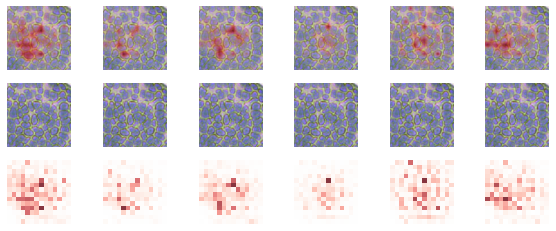

HT206B1_H8_U5_TAGAGATCATGCAACT-1 tensor([ 0.0536,  0.0037, -0.0085,  0.0648,  0.0043,  0.0227,  0.0515,  0.0744,
         0.3287,  0.0259,  0.0904,  0.3608,  0.0251, -0.0307])


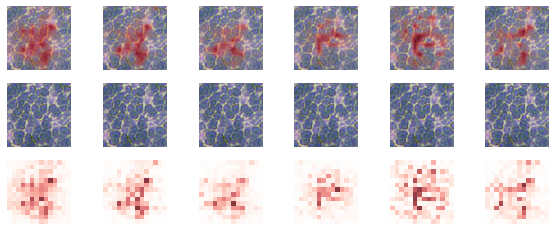

HT206B1_H8_U5_TTGAGAAGTTTAGCAT-1 tensor([ 0.0708,  0.0314,  0.0113,  0.0651, -0.0076,  0.0246,  0.0200,  0.1894,
         0.3285, -0.0470,  0.1686,  0.5324, -0.0305, -0.1711])


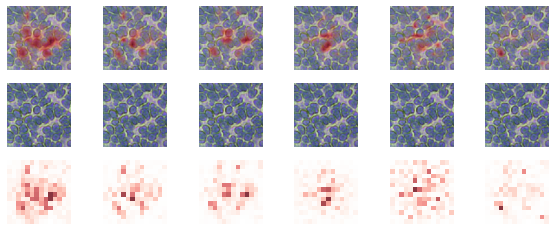

HT206B1_H8_U4_CTGGGCCTGCTATATC-1 tensor([ 0.0925, -0.0716,  0.0391,  0.1343, -0.0456,  0.0033,  0.0852,  0.1131,
         0.3091,  0.0391,  0.1241,  0.3603,  0.0235, -0.1007])


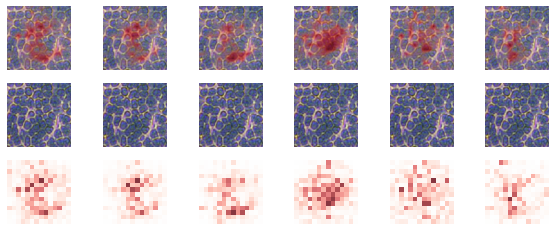

HT206B1_H8_U3_CTGGGCCTGCTATATC-1 tensor([ 0.0344,  0.0343,  0.0810,  0.0604,  0.1167,  0.0094,  0.0177,  0.0980,
         0.3070, -0.0170,  0.1430,  0.4091, -0.0411, -0.1009])


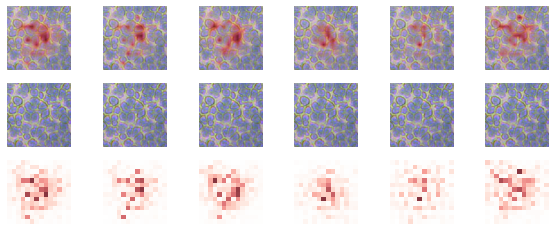

In [130]:
display_attns(pred_dataloader, 'DC', predictions, attns)

HT206B1_H8_U2_TCCGTTTAGCCTTGAA-1 tensor([-0.0080,  0.0944,  0.4096,  0.0031,  0.0652,  0.0670, -0.1402,  0.0247,
        -0.0004,  0.0077,  0.0545, -0.0325,  0.1048,  0.2408])


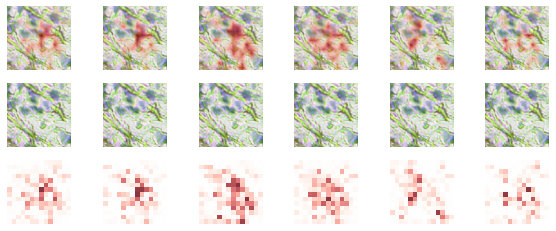

HT206B1_H8_U2_GCCTATAGTGTCAGGG-1 tensor([-0.0202,  0.0938,  0.3954, -0.0297,  0.0260,  0.1480, -0.0992,  0.0370,
         0.0166,  0.0507,  0.0999,  0.0469,  0.0270,  0.2435])


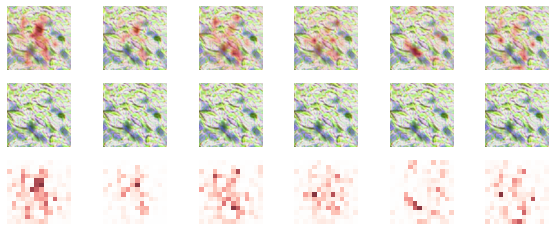

HT206B1_H8_U3_GATCGGTGGCCATAAC-1 tensor([ 4.5574e-02,  1.1813e-01,  3.9255e-01,  1.0951e-02, -4.1901e-03,
         8.6982e-02, -4.9550e-02,  2.6912e-03,  1.9087e-04,  2.6898e-02,
         2.9836e-02,  1.9048e-01, -2.9751e-02,  1.5801e-01])


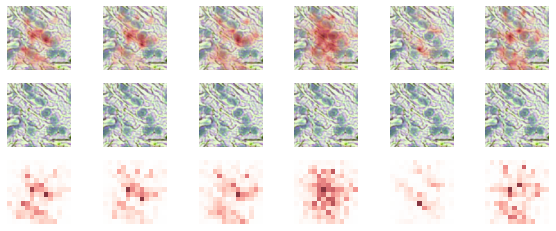

HT206B1_H8_U2_TTCTACCTCAATCGGT-1 tensor([-0.1368,  0.2506,  0.3898, -0.0381,  0.0402,  0.1253, -0.0491, -0.0262,
         0.0218,  0.0408,  0.0867,  0.2753,  0.0320,  0.1333])


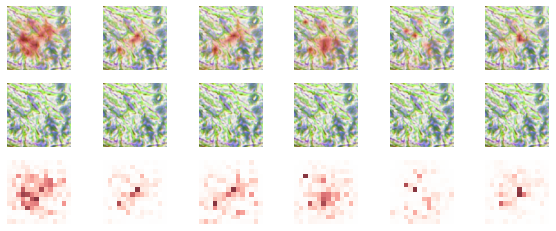

HT206B1_H8_U4_GGAGTTGATTCTGTGT-1 tensor([-0.0487,  0.0724,  0.3891,  0.0206,  0.0325,  0.1053, -0.1894, -0.0118,
        -0.0182,  0.0049,  0.0621, -0.0442, -0.0391,  0.4678])


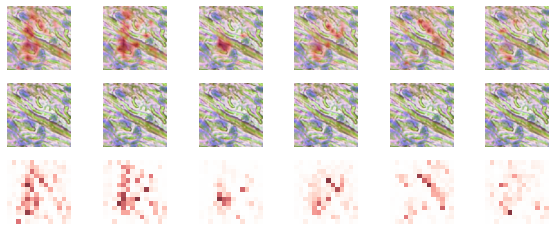

In [131]:
display_attns(pred_dataloader, 'CAF', predictions, attns)

HT206B1_H8_U3_TCACAGGTTATTGGGC-1 tensor([-0.0261, -0.0668, -0.0374,  0.1765,  0.0041, -0.0879, -0.0264,  0.0304,
        -0.0650, -0.0465, -0.0232, -0.0521, -0.0233,  1.1552])


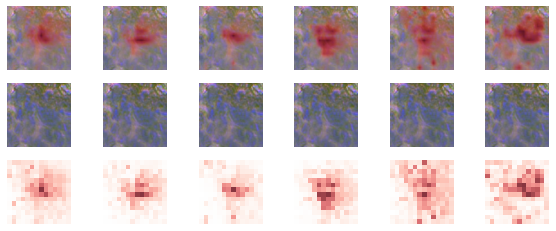

HT206B1_H8_U4_CGTCTTGAGTGTGACG-1 tensor([-0.0040, -0.0737, -0.0633,  0.1319,  0.0016, -0.0200, -0.1659,  0.0657,
        -0.0371,  0.0488,  0.0238, -0.0395,  0.0168,  1.1322])


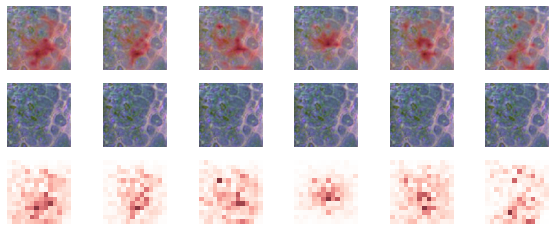

HT206B1_H8_U3_TGCAAAGTTCGTCTGT-1 tensor([ 0.0328, -0.0369,  0.0527,  0.0412,  0.0073,  0.0174,  0.1350,  0.0682,
         0.0755,  0.0678,  0.0730, -0.0953,  0.0929,  1.1308])


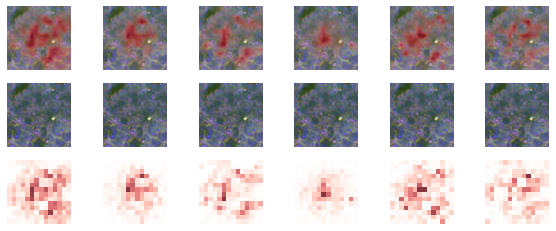

HT206B1_H8_U5_ATACGAAGGCTTTCCA-1 tensor([ 0.0206, -0.0741, -0.0189,  0.1100,  0.0796, -0.0693,  0.0416,  0.0538,
        -0.0625, -0.0246,  0.0030, -0.1206,  0.0266,  1.1277])


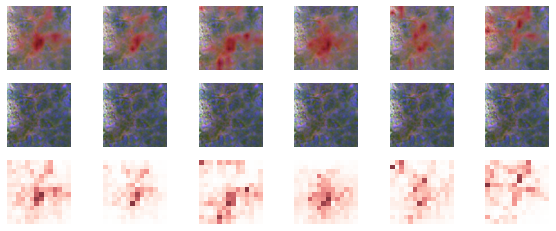

HT206B1_H8_U4_GCGGGCGAGCCTTACC-1 tensor([-0.0572, -0.0359, -0.0699,  0.2075,  0.0060,  0.0258, -0.0233,  0.0273,
        -0.0469, -0.0135, -0.0179, -0.0801,  0.0174,  1.1033])


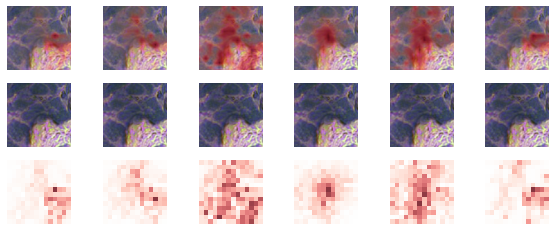

In [132]:
display_attns(pred_dataloader, 'Tumor', predictions, attns)

In [133]:
fmap = pd.read_csv('/home/estorrs/spatial-analysis/data/sample_map.txt', sep='\t', index_col=0)
fmap

spaceranger_output  \
sample_id                                                          
HT206B1_H8_U2  /data/spatial_transcriptomics/spaceranger_outp...   
HT206B1_H8_U3  /data/spatial_transcriptomics/spaceranger_outp...   
HT206B1_H8_U4  /data/spatial_transcriptomics/spaceranger_outp...   
HT206B1_H8_U5  /data/spatial_transcriptomics/spaceranger_outp...   
HT206B1_H8_Bn  /data/spatial_transcriptomics/spaceranger_outp...   
...                                                          ...   
NMK_20201012   /data/spatial_transcriptomics/spaceranger_outp...   
AKICL_14w      /data/spatial_transcriptomics/spaceranger_outp...   
AKI_M_14w      /data/spatial_transcriptomics/spaceranger_outp...   
SP1896H1_U1    /data/spatial_transcriptomics/spaceranger_outp...   
HT291C1_U1     /data/spatial_transcriptomics/spaceranger_outp...   

                                                   highres_image  \
sample_id                                                          
HT206B1_H8_U2  /data/spatial_transcriptomics/highres_images/b...   
HT206B1_H8_U3  /data/spatial_transcriptomics/highres_images/b...   
HT206B1_H8_U4  /data/spatial_transcriptomics/highres_images/b...   
HT206B1_H8_U5  /data/spatial_transcriptomics/highres_images/b...   
HT206B1_H8_Bn                                                NaN   
...                                                          ...   
NMK_20201012   /data/spatial_transcriptomics/highres_images/m...   
AKICL_14w      /data/spatial_transcriptomics/highres_images/m...   
AKI_M_14w      /data/spatial_transcriptomics/highres_images/m...   
SP1896H1_U1    /data/spatial_transcriptomics/highres_images/i...   
HT291C1_U1     /data/spatial_transcriptomics/highres_images/i...   

                      disease  
sample_id                      
HT206B1_H8_U2            brca  
HT206B1_H8_U3            brca  
HT206B1_H8_U4            brca  
HT206B1_H8_U5            brca  
HT206B1_H8_Bn            brca  
...                       ...  
NMK_20201012     mouse_kidney  
AKICL_14w        mouse_kidney  
AKI_M_14w        mouse_kidney  
SP1896H1_U1    normal_stomach  
HT291C1_U1       normal_liver  

[90 rows x 3 columns]

In [165]:
# visualize
s_id = 'HT206B1_H8_U4'
a = sc.read_visium(pd.read_csv('/home/estorrs/spatial-analysis/data/sample_map.txt', sep='\t', index_col=0
    ).loc[s_id, 'spaceranger_output'])
a.var_names_make_unique()
a.obs.index = [f'{s_id}_{x}' for x in a.obs.index]
a

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 4132 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [168]:
idxs = [i for i, x in enumerate(pred_dataloader.dataset.samples) if s_id in x]
len(idxs)

4132

In [169]:
# threshold to 0
predictions[predictions<0.] = 0.

In [170]:
pred_df = pd.DataFrame(data=predictions.cpu().numpy(), columns=list(pred_dataloader.dataset.labels),
                       index=list(pred_dataloader.dataset.samples))
pred_df.columns = [f'predicted {c}' for c in pred_df.columns]
pred_df

predicted CD8-T  predicted Endothelial  \
HT206B1_H8_U2_ACCTACAGTATGTGGT-1         0.000000               0.060872   
HT206B1_H8_U2_AGCAACATATCTTATT-1         0.009646               0.059752   
HT206B1_H8_U2_ATAGTTCCACCCACTC-1         0.028201               0.055213   
HT206B1_H8_U2_ATATCAACCTACAGAG-1         0.019004               0.008756   
HT206B1_H8_U2_ATTAATTCGGTCACTC-1         0.007789               0.034343   
...                                           ...                    ...   
HT206B1_H8_U5_TTGTGGCCCTGACAGT-1         0.000000               0.000000   
HT206B1_H8_U5_TTGTGGTATAGGTATG-1         0.000000               0.000000   
HT206B1_H8_U5_TTGTGGTGGTACTAAG-1         0.000000               0.000000   
HT206B1_H8_U5_TTGTTAGCAAATTCGA-1         0.000000               0.000000   
HT206B1_H8_U5_TTGTTTGTGTAAATTC-1         0.000000               0.000000   

                                  predicted CAF  predicted Normal-duct  \
HT206B1_H8_U2_ACCTACAGTATGTGGT-1       0.000000               0.036928   
HT206B1_H8_U2_AGCAACATATCTTATT-1       0.000000               0.040344   
HT206B1_H8_U2_ATAGTTCCACCCACTC-1       0.000000               0.152824   
HT206B1_H8_U2_ATATCAACCTACAGAG-1       0.010219               0.128926   
HT206B1_H8_U2_ATTAATTCGGTCACTC-1       0.168324               0.055891   
...                                         ...                    ...   
HT206B1_H8_U5_TTGTGGCCCTGACAGT-1       0.000000               0.000000   
HT206B1_H8_U5_TTGTGGTATAGGTATG-1       0.000000               0.000000   
HT206B1_H8_U5_TTGTGGTGGTACTAAG-1       0.000000               0.000000   
HT206B1_H8_U5_TTGTTAGCAAATTCGA-1       0.000000               0.000000   
HT206B1_H8_U5_TTGTTTGTGTAAATTC-1       0.000000               0.000000   

                                  predicted NK  predicted Mono-Macro  \
HT206B1_H8_U2_ACCTACAGTATGTGGT-1      0.000000              0.030441   
HT206B1_H8_U2_AGCAACATATCTTATT-1      0.006855              0.072225   
HT206B1_H8_U2_ATAGTTCCACCCACTC-1      0.083671              0.000000   
HT206B1_H8_U2_ATATCAACCTACAGAG-1      0.000000              0.049313   
HT206B1_H8_U2_ATTAATTCGGTCACTC-1      0.007903              0.146893   
...                                        ...                   ...   
HT206B1_H8_U5_TTGTGGCCCTGACAGT-1      0.000000              0.000000   
HT206B1_H8_U5_TTGTGGTATAGGTATG-1      0.000000              0.000000   
HT206B1_H8_U5_TTGTGGTGGTACTAAG-1      0.000000              0.000000   
HT206B1_H8_U5_TTGTTAGCAAATTCGA-1      0.000000              0.000000   
HT206B1_H8_U5_TTGTTTGTGTAAATTC-1      0.000000              0.000000   

                                  predicted Treg  predicted CD4-T  \
HT206B1_H8_U2_ACCTACAGTATGTGGT-1        0.012396         0.125971   
HT206B1_H8_U2_AGCAACATATCTTATT-1        0.008496         0.101680   
HT206B1_H8_U2_ATAGTTCCACCCACTC-1        0.029578         0.187991   
HT206B1_H8_U2_ATATCAACCTACAGAG-1        0.009442         0.069130   
HT206B1_H8_U2_ATTAATTCGGTCACTC-1        0.020075         0.000000   
...                                          ...              ...   
HT206B1_H8_U5_TTGTGGCCCTGACAGT-1        0.000000         0.000000   
HT206B1_H8_U5_TTGTGGTATAGGTATG-1        0.000000         0.000000   
HT206B1_H8_U5_TTGTGGTGGTACTAAG-1        0.000000         0.000000   
HT206B1_H8_U5_TTGTTAGCAAATTCGA-1        0.000000         0.000000   
HT206B1_H8_U5_TTGTTTGTGTAAATTC-1        0.000000         0.000000   

                                  predicted DC  predicted NKT-cells  \
HT206B1_H8_U2_ACCTACAGTATGTGGT-1      0.062319             0.016795   
HT206B1_H8_U2_AGCAACATATCTTATT-1      0.123054             0.000000   
HT206B1_H8_U2_ATAGTTCCACCCACTC-1      0.102997             0.000000   
HT206B1_H8_U2_ATATCAACCTACAGAG-1      0.055245             0.000000   
HT206B1_H8_U2_ATTAATTCGGTCACTC-1      0.080985             0.008493   
...                                        ...                  ...   
HT206B1_H8_U5_TTGTGGCCCTGACAGT-1      0.0

In [171]:
a.obs = pd.merge(a.obs, pred_df.loc[a.obs.index], left_index=True, right_index=True)
a.obs

in_tissue  array_row  array_col  \
HT206B1_H8_U4_AAACAACGAATAGTTC-1          1          0         16   
HT206B1_H8_U4_AAACAAGTATCTCCCA-1          1         50        102   
HT206B1_H8_U4_AAACAATCTACTAGCA-1          1          3         43   
HT206B1_H8_U4_AAACACCAATAACTGC-1          1         59         19   
HT206B1_H8_U4_AAACAGAGCGACTCCT-1          1         14         94   
...                                     ...        ...        ...   
HT206B1_H8_U4_TTGTTTCACATCCAGG-1          1         58         42   
HT206B1_H8_U4_TTGTTTCATTAGTCTA-1          1         60         30   
HT206B1_H8_U4_TTGTTTCCATACAACT-1          1         45         27   
HT206B1_H8_U4_TTGTTTGTATTACACG-1          1         73         41   
HT206B1_H8_U4_TTGTTTGTGTAAATTC-1          1          7         51   

                                  predicted CD8-T  predicted Endothelial  \
HT206B1_H8_U4_AAACAACGAATAGTTC-1         0.000000               0.041162   
HT206B1_H8_U4_AAACAAGTATCTCCCA-1         0.017214               0.037757   
HT206B1_H8_U4_AAACAATCTACTAGCA-1         0.000000               0.054272   
HT206B1_H8_U4_AAACACCAATAACTGC-1         0.000000               0.064333   
HT206B1_H8_U4_AAACAGAGCGACTCCT-1         0.004278               0.125808   
...                                           ...                    ...   
HT206B1_H8_U4_TTGTTTCACATCCAGG-1         0.005277               0.092688   
HT206B1_H8_U4_TTGTTTCATTAGTCTA-1         0.000000               0.106334   
HT206B1_H8_U4_TTGTTTCCATACAACT-1         0.035269               0.043093   
HT206B1_H8_U4_TTGTTTGTATTACACG-1         0.029505               0.215906   
HT206B1_H8_U4_TTGTTTGTGTAAATTC-1         0.025085               0.040837   

                                  predicted CAF  predicted Normal-duct  \
HT206B1_H8_U4_AAACAACGAATAGTTC-1       0.189187               0.062053   
HT206B1_H8_U4_AAACAAGTATCTCCCA-1       0.015215               0.111934   
HT206B1_H8_U4_AAACAATCTACTAGCA-1       0.159076               0.119256   
HT206B1_H8_U4_AAACACCAATAACTGC-1       0.227196               0.035901   
HT206B1_H8_U4_AAACAGAGCGACTCCT-1       0.153842               0.070955   
...                                         ...                    ...   
HT206B1_H8_U4_TTGTTTCACATCCAGG-1       0.111241               0.064335   
HT206B1_H8_U4_TTGTTTCATTAGTCTA-1       0.101713               0.021394   
HT206B1_H8_U4_TTGTTTCCATACAACT-1       0.000000               0.138077   
HT206B1_H8_U4_TTGTTTGTATTACACG-1       0.118966               0.106110   
HT206B1_H8_U4_TTGTTTGTGTAAATTC-1       0.161064               0.000000   

                                  predicted NK  predicted Mono-Macro  \
HT206B1_H8_U4_AAACAACGAATAGTTC-1      0.004648              0.112592   
HT206B1_H8_U4_AAACAAGTATCTCCCA-1      0.057416              0.037906   
HT206B1_H8_U4_AAACAATCTACTAGCA-1      0.039863              0.081706   
HT206B1_H8_U4_AAACACCAATAACTGC-1      0.005931              0.000000   
HT206B1_H8_U4_AAACAGAGCGACTCCT-1      0.037602              0.003827   
...                                        ...                   ...   
HT206B1_H8_U4_TTGTTTCACATCCAGG-1      0.000000              0.083035   
HT206B1_H8_U4_TTGTTTCATTAGTCTA-1      0.000000              0.013188   
HT206B1_H8_U4_TTGTTTCCATACAACT-1      0.000000              0.000000   
HT206B1_H8_U4_TTGTTTGTATTACACG-1      0.000000              0.063248   
HT206B1_H8_U4_TTGTTTGTGTAAATTC-1      0.050960              0.047969   

                                  predicted Treg  predicted CD4-T  \
HT206B1_H8_U4_AAACAACGAATAGTTC-1        0.000000         0.017784   
HT206B1_H8_U4_AAACAAGTATCTCCCA-1        0.085025         0.016722   
HT206B1_H8_U4_AAACAATCTACTAGCA-1        0.049893         0.024178   
HT206B1_H8_U4_AAACACCAATAACTGC-1        0.000000         0.019007   
HT206B1_H8_U4_AAACAGAGCGACTCCT-1        0.000000         0.021058   
...                                          ...              ...   
HT206B1_H8_U4_TTGTTTCACATCCAGG-1        0.010356       

In [172]:
t = targets.copy()
t.columns = [f'groundtruth {c}' for c in t.columns]
a.obs = pd.merge(a.obs, t.loc[a.obs.index], left_index=True, right_index=True)
a.obs

in_tissue  array_row  array_col  \
HT206B1_H8_U4_AAACAACGAATAGTTC-1          1          0         16   
HT206B1_H8_U4_AAACAAGTATCTCCCA-1          1         50        102   
HT206B1_H8_U4_AAACAATCTACTAGCA-1          1          3         43   
HT206B1_H8_U4_AAACACCAATAACTGC-1          1         59         19   
HT206B1_H8_U4_AAACAGAGCGACTCCT-1          1         14         94   
...                                     ...        ...        ...   
HT206B1_H8_U4_TTGTTTCACATCCAGG-1          1         58         42   
HT206B1_H8_U4_TTGTTTCATTAGTCTA-1          1         60         30   
HT206B1_H8_U4_TTGTTTCCATACAACT-1          1         45         27   
HT206B1_H8_U4_TTGTTTGTATTACACG-1          1         73         41   
HT206B1_H8_U4_TTGTTTGTGTAAATTC-1          1          7         51   

                                  predicted CD8-T  predicted Endothelial  \
HT206B1_H8_U4_AAACAACGAATAGTTC-1         0.000000               0.041162   
HT206B1_H8_U4_AAACAAGTATCTCCCA-1         0.017214               0.037757   
HT206B1_H8_U4_AAACAATCTACTAGCA-1         0.000000               0.054272   
HT206B1_H8_U4_AAACACCAATAACTGC-1         0.000000               0.064333   
HT206B1_H8_U4_AAACAGAGCGACTCCT-1         0.004278               0.125808   
...                                           ...                    ...   
HT206B1_H8_U4_TTGTTTCACATCCAGG-1         0.005277               0.092688   
HT206B1_H8_U4_TTGTTTCATTAGTCTA-1         0.000000               0.106334   
HT206B1_H8_U4_TTGTTTCCATACAACT-1         0.035269               0.043093   
HT206B1_H8_U4_TTGTTTGTATTACACG-1         0.029505               0.215906   
HT206B1_H8_U4_TTGTTTGTGTAAATTC-1         0.025085               0.040837   

                                  predicted CAF  predicted Normal-duct  \
HT206B1_H8_U4_AAACAACGAATAGTTC-1       0.189187               0.062053   
HT206B1_H8_U4_AAACAAGTATCTCCCA-1       0.015215               0.111934   
HT206B1_H8_U4_AAACAATCTACTAGCA-1       0.159076               0.119256   
HT206B1_H8_U4_AAACACCAATAACTGC-1       0.227196               0.035901   
HT206B1_H8_U4_AAACAGAGCGACTCCT-1       0.153842               0.070955   
...                                         ...                    ...   
HT206B1_H8_U4_TTGTTTCACATCCAGG-1       0.111241               0.064335   
HT206B1_H8_U4_TTGTTTCATTAGTCTA-1       0.101713               0.021394   
HT206B1_H8_U4_TTGTTTCCATACAACT-1       0.000000               0.138077   
HT206B1_H8_U4_TTGTTTGTATTACACG-1       0.118966               0.106110   
HT206B1_H8_U4_TTGTTTGTGTAAATTC-1       0.161064               0.000000   

                                  predicted NK  predicted Mono-Macro  \
HT206B1_H8_U4_AAACAACGAATAGTTC-1      0.004648              0.112592   
HT206B1_H8_U4_AAACAAGTATCTCCCA-1      0.057416              0.037906   
HT206B1_H8_U4_AAACAATCTACTAGCA-1      0.039863              0.081706   
HT206B1_H8_U4_AAACACCAATAACTGC-1      0.005931              0.000000   
HT206B1_H8_U4_AAACAGAGCGACTCCT-1      0.037602              0.003827   
...                                        ...                   ...   
HT206B1_H8_U4_TTGTTTCACATCCAGG-1      0.000000              0.083035   
HT206B1_H8_U4_TTGTTTCATTAGTCTA-1      0.000000              0.013188   
HT206B1_H8_U4_TTGTTTCCATACAACT-1      0.000000              0.000000   
HT206B1_H8_U4_TTGTTTGTATTACACG-1      0.000000              0.063248   
HT206B1_H8_U4_TTGTTTGTGTAAATTC-1      0.050960              0.047969   

                                  predicted Treg  ...  groundtruth NK  \
HT206B1_H8_U4_AAACAACGAATAGTTC-1        0.000000  ...             0.0   
HT206B1_H8_U4_AAACAAGTATCTCCCA-1        0.085025  ...             0.0   
HT206B1_H8_U4_AAACAATCTACTAGCA-1        0.049893  ...             0.0   
HT206B1_H8_U4_AAACACCAATAACTGC-1        0.000000  ...             0.0   
HT206B1_H8_U4_AAACAGAGCGACTCCT-1        0.000000  ...             0.0   
...                                          ...  ...             ...   
HT206B1_H8_U4_TTGTTTCACATCC

... storing 'feature_types' as categorical
... storing 'genome' as categorical


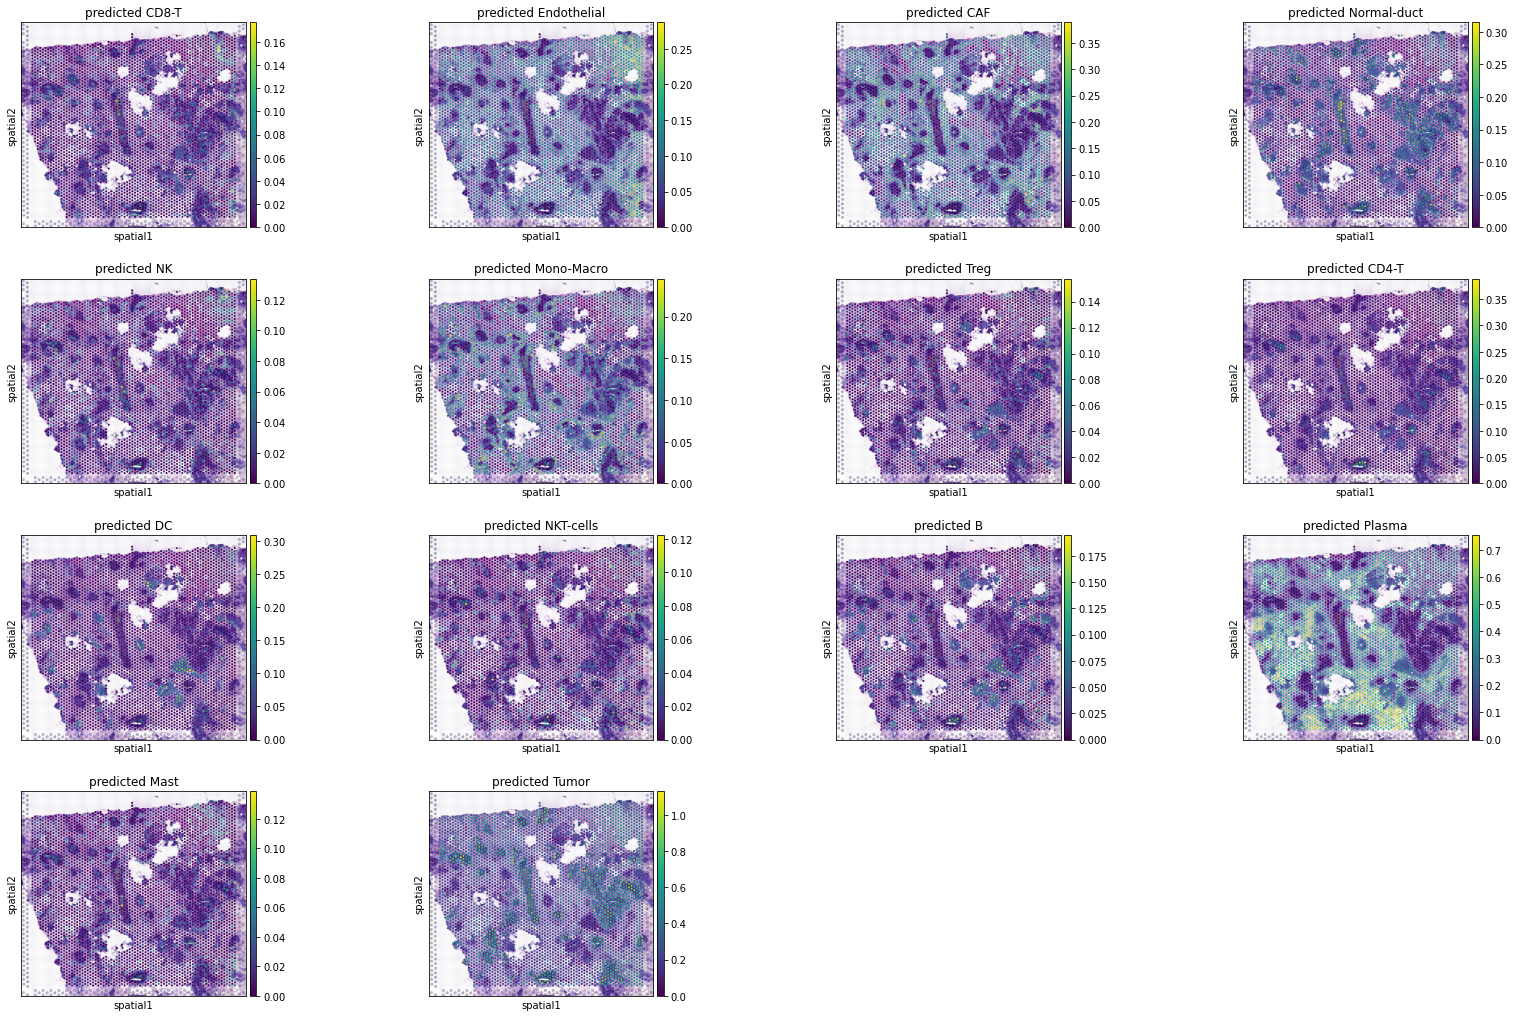

In [173]:
sc.pl.spatial(a, color=[c for c in a.obs.columns if 'predicted' in c])

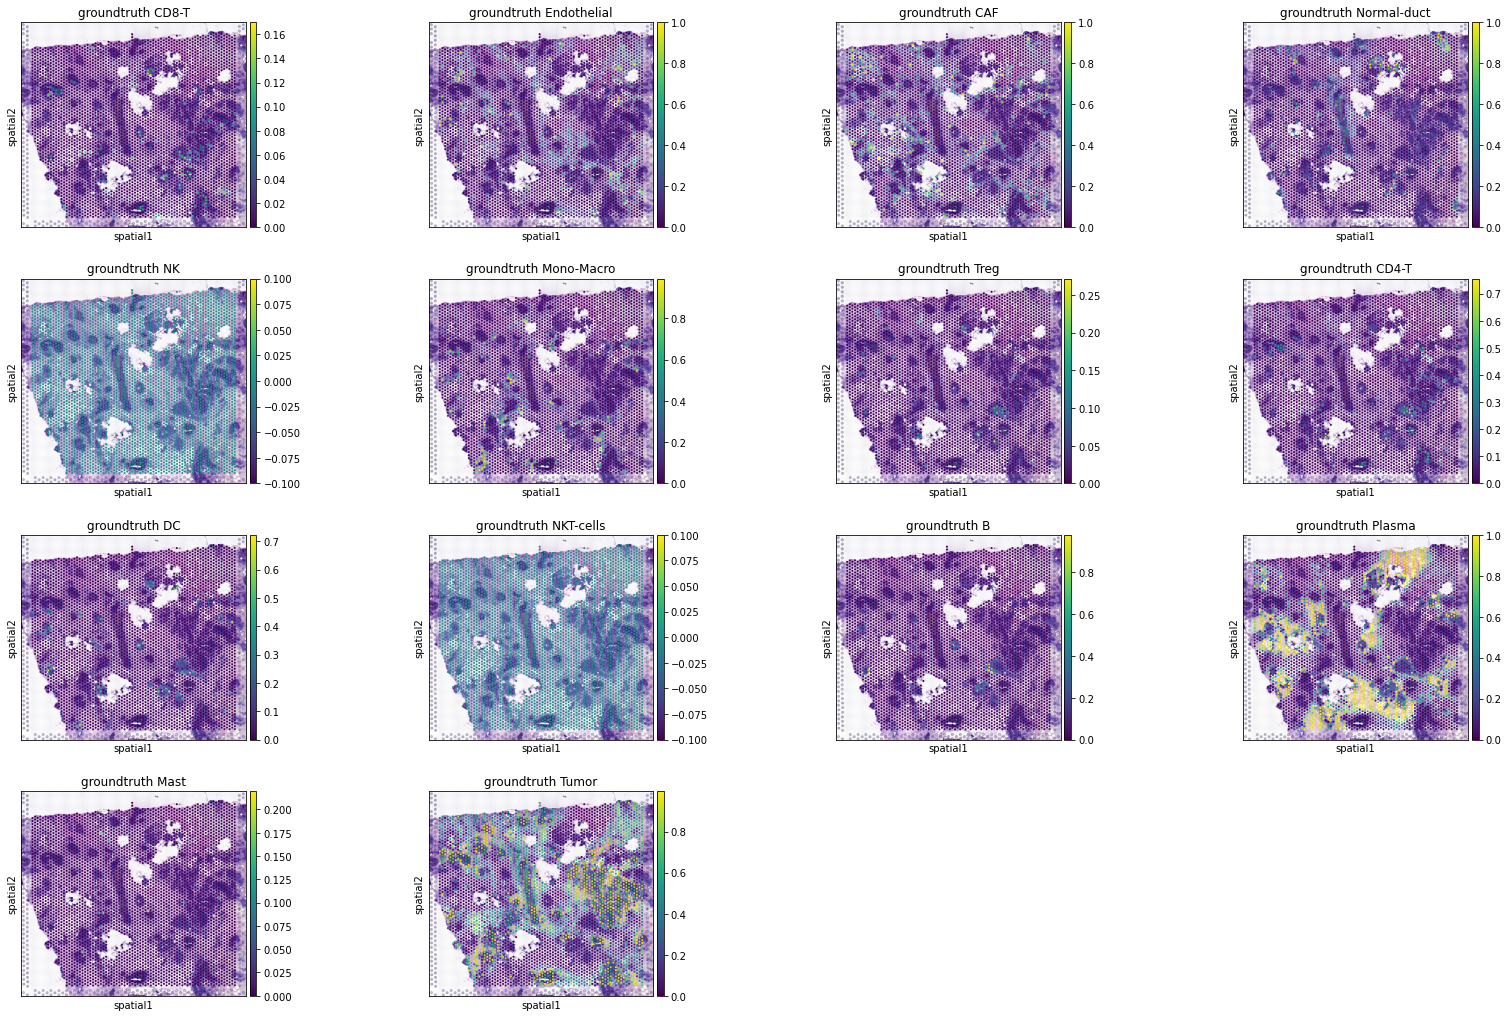

In [174]:
sc.pl.spatial(a, color=[c for c in a.obs.columns if 'groundtruth' in c])

In [145]:
model.eval()
embs = torch.zeros((len(pred_dataloader.dataset.samples), 384))
with torch.no_grad():
    for i, (x, y) in enumerate(pred_dataloader):
        x, y = x.cuda(), y.cuda()
        emb = model(x)
        embs[i*64:(i+1)*64] = emb
embs = embs.cpu().numpy()

In [146]:
embs.shape

(16666, 384)

In [159]:
from umap import UMAP
embs_umap = UMAP().fit_transform(embs)
embs_umap.shape

(16666, 2)

In [162]:
all_adata = anndata.AnnData(X=embs.copy())
all_adata.obs.index = list(pred_dataloader.dataset.samples)
all_adata.obs['sample'] = ['_'.join(x.split('_')[:-1]) for x in all_adata.obs.index]
all_adata.obsm['X_umap'] = embs_umap


... storing 'sample' as categorical


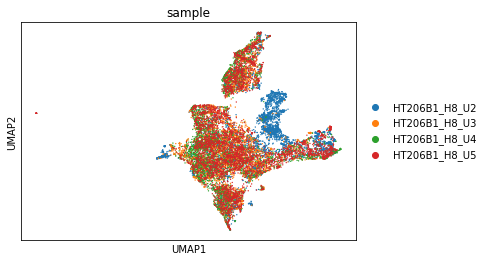

In [163]:
sc.pl.umap(all_adata, color='sample')

In [148]:
idxs = [i for i, x in enumerate(pred_dataloader.dataset.samples) if s_id in x]
len(idxs)

4311

In [175]:
import anndata
emb_adata = anndata.AnnData(X=embs[idxs].copy(), obs=a.obs.copy())
emb_adata

AnnData object with n_obs × n_vars = 4132 × 384
    obs: 'in_tissue', 'array_row', 'array_col', 'predicted CD8-T', 'predicted Endothelial', 'predicted CAF', 'predicted Normal-duct', 'predicted NK', 'predicted Mono-Macro', 'predicted Treg', 'predicted CD4-T', 'predicted DC', 'predicted NKT-cells', 'predicted B', 'predicted Plasma', 'predicted Mast', 'predicted Tumor', 'groundtruth CD8-T', 'groundtruth Endothelial', 'groundtruth CAF', 'groundtruth Normal-duct', 'groundtruth NK', 'groundtruth Mono-Macro', 'groundtruth Treg', 'groundtruth CD4-T', 'groundtruth DC', 'groundtruth NKT-cells', 'groundtruth B', 'groundtruth Plasma', 'groundtruth Mast', 'groundtruth Tumor'

In [176]:
sc.pp.neighbors(emb_adata)
sc.tl.umap(emb_adata)
sc.tl.leiden(emb_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


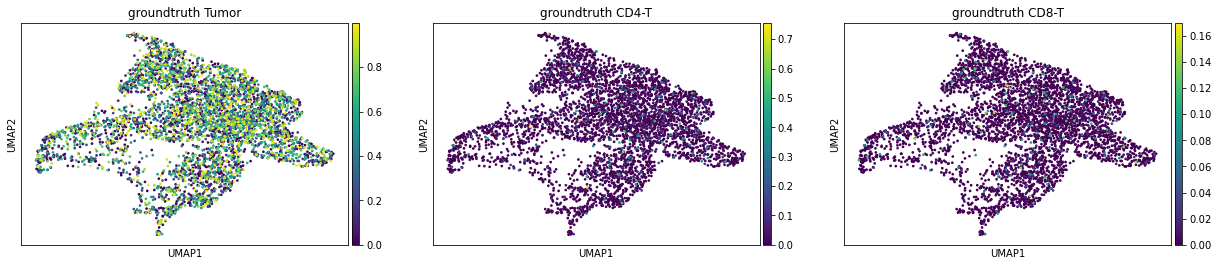

In [177]:
sc.pl.umap(emb_adata, color=['groundtruth Tumor', 'groundtruth CD4-T', 'groundtruth CD8-T'])

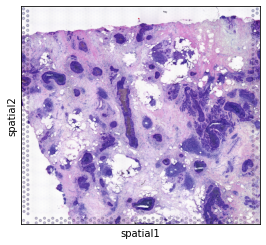

In [178]:
sc.pl.spatial(a)

In [266]:
# try a vanilla resnet
resnet = torchvision_models.resnet50(pretrained=True, )

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/estorrs/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [268]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [269]:
class TestModel2(nn.Module):
    def __init__(self, hidden_dim, out_dim, drop=0.):
        super().__init__()
        
        self.vit = torchvision_models.resnet50(pretrained=True,)
        self.head = RegressionHead(1000, hidden_dim, out_dim, drop=drop)
        
        # freeze vit weights
        for param in self.vit.parameters():
            param.requires_grad = False
            
    def unfreeze_vit(self):
        for param in self.vit.parameters():
            param.requires_grad = True
        
    def forward(self, x):
        cls_token = self.vit(x)
        return self.head(cls_token)
        

In [270]:
clf = TestModel2(1000, len(train_data_loader.dataset.labels), drop=.2)
clf = clf.cuda()

In [271]:
max_lr = 1e-4
epochs = 10

mse_loss = nn.MSELoss()
opt = torch.optim.Adam(clf.parameters(), lr=max_lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=max_lr,
                                                steps_per_epoch=len(train_dataloader), epochs=epochs)

In [272]:
for epoch in range(epochs):
    train_loss, val_loss = 0., 0.
    
    clf.train()
    for i, (x, y) in enumerate(train_dataloader):
        x, y = x.cuda(), y.cuda()
        logit = clf(x)
        loss = mse_loss(logit, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
                
        train_loss += loss
    scheduler.step()
        
    clf.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(val_dataloader):
            x, y = x.cuda(), y.cuda()
            logit = clf(x)
            loss = mse_loss(logit, y)
            
            val_loss += loss    

    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    
    print(f'epoch: {epoch}, train loss: {train_loss}, val loss: {val_loss}')


epoch: 0, train loss: 0.044483184814453125, val loss: 0.02978304773569107
epoch: 1, train loss: 0.035904232412576675, val loss: 0.027648789808154106
epoch: 2, train loss: 0.032724108546972275, val loss: 0.026578325778245926
epoch: 3, train loss: 0.030656902119517326, val loss: 0.025800256058573723
epoch: 4, train loss: 0.029157264158129692, val loss: 0.02522815577685833
epoch: 5, train loss: 0.027988268062472343, val loss: 0.024853114038705826
epoch: 6, train loss: 0.027104321867227554, val loss: 0.024541474878787994
epoch: 7, train loss: 0.026492370292544365, val loss: 0.024345768615603447
epoch: 8, train loss: 0.025898616760969162, val loss: 0.024103866890072823
epoch: 9, train loss: 0.025374174118041992, val loss: 0.023977005854249


In [273]:
# unfreeze vit
clf.unfreeze_vit()

In [274]:
max_lr = 1e-5
epochs = 10

mse_loss = nn.MSELoss()
opt = torch.optim.Adam(clf.parameters(), lr=max_lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=max_lr,
                                                steps_per_epoch=len(train_dataloader), epochs=epochs)

In [275]:
for epoch in range(epochs):
    train_loss, val_loss = 0., 0.
    
    clf.train()
    for i, (x, y) in enumerate(train_dataloader):
        x, y = x.cuda(), y.cuda()
        logit = clf(x)
        loss = mse_loss(logit, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
                
        train_loss += loss
    scheduler.step()
        
    clf.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(val_dataloader):
            x, y = x.cuda(), y.cuda()
            logit = clf(x)
            loss = mse_loss(logit, y)
            
            val_loss += loss    

    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    
    print(f'epoch: {epoch}, train loss: {train_loss}, val loss: {val_loss}')


epoch: 0, train loss: 0.025024494156241417, val loss: 0.02388659119606018
epoch: 1, train loss: 0.024879215285182, val loss: 0.02377578243613243
epoch: 2, train loss: 0.024637140333652496, val loss: 0.023710615932941437


KeyboardInterrupt: 